In [1]:
import os
import math
import ROOT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import HTML

In [2]:
#generator of shape image
def plot_grid(path, num, shape):
    file_path = f'{path}/shapes_img/graph_{shape[0]}_{shape[1]}_{num}.png'
    
    if not os.path.exists(f'{path}/shapes_img'):
        os.makedirs(f'{path}/shapes_img')
    
    # Check if the shape already exists to skip its generation
    if not os.path.exists(file_path):
        #decode the key
        bits = [(num >> i) & 1 for i in range(shape[0]*shape[1])]
        #reshape it into the cluster grid dimension
        grid = np.array(bits).reshape(shape)
        #apply color mask - 0 = gray, 1 = red
        colors = np.array(['gray', 'red'])
        color_grid = colors[grid]
        #generate shape image
        fig, ax = plt.subplots()
        for i in range(shape[0]):
            for j in range(shape[1]):
                ax.add_patch(plt.Rectangle((j, shape[0]-1-i), 1, 1, color=color_grid[i, j]))
        ax.set_xlim(0, shape[1])
        ax.set_ylim(0, shape[0])
        ax.set_aspect('equal')
        ax.axis('off')
        plt.savefig(f'{path}/shapes_img/graph_{shape[0]}_{shape[1]}_{num}.png')
        plt.close(fig)
    #return html path for the image embedding
    return f'<img src="shapes_img/graph_{shape[0]}_{shape[1]}_{num}.png" width="75" height="50">'

In [3]:
# Convert TH histogram to numpy arrays for matplotlib plotting
def convertTH(hist):
    bin_edges = np.array([hist.GetBinLowEdge(i) for i in range(1, hist.GetNbinsX() + 2)])
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_contents = np.array([hist.GetBinContent(i) for i in range(1, hist.GetNbinsX() + 1)])
    bin_errors = np.array([hist.GetBinError(i) for i in range(1, hist.GetNbinsX() + 1)])
    return bin_centers, bin_contents, bin_errors

In [4]:
# Convert THGraphAssymErrors to numpy arrays for matplotlib plotting
def convertGraph(graph):
    """
    Convert a TGraphAsymmErrors into NumPy arrays for plotting.

    Returns:
        x (bin centers), y (values), yerr_low, yerr_up
    """
    n_points = graph.GetN()
    x = np.array([graph.GetX()[i] for i in range(n_points)])
    y = np.array([graph.GetY()[i] for i in range(n_points)])
    xerr_low = np.array([graph.GetErrorXlow(i) for i in range(n_points)])
    xerr_up = np.array([graph.GetErrorXhigh(i) for i in range(n_points)])
    yerr_low = np.array([graph.GetErrorYlow(i) for i in range(n_points)])
    yerr_up = np.array([graph.GetErrorYhigh(i) for i in range(n_points)])
    return x, y, xerr_low, xerr_up, yerr_low, yerr_up

In [5]:
# Convert TEfficiency histogram to numpy arrays for matplotlib plotting
def convertTEfficiency(eff):
    nbins = eff.GetTotalHistogram().GetNbinsX()
    bin_edges = np.array([eff.GetTotalHistogram().GetBinLowEdge(i) for i in range(1, nbins + 2)])
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    efficiencies = np.array([eff.GetEfficiency(i) for i in range(1, nbins + 1)])
    err_low = np.array([eff.GetEfficiencyErrorLow(i) for i in range(1, nbins + 1)])
    err_up = np.array([eff.GetEfficiencyErrorUp(i) for i in range(1, nbins + 1)])
    #guard, there should not be engatives
    err_low = np.array([max(0.0, eff.GetEfficiencyErrorLow(i)) for i in range(1, nbins + 1)])
    err_up = np.array([max(0.0, eff.GetEfficiencyErrorUp(i)) for i in range(1, nbins + 1)])
    return bin_centers, efficiencies, err_low, err_up

In [26]:
#GLOBALS
input_path = "/eos/user/j/jkvapil/SWAN_projects/sPHENIX"
input_names = "MVTX_ME_AuAu_shapes.root" #this can be a chain i.e MVTX_ME_pp_shapes_0*.root
output_path = "/eos/user/j/jkvapil/SWAN_projects/sPHENIX"
col_system = 'AuAu'
run_number = "54966"
#eta cut due to worse PID efficiency while keeping it 1.1
eta_cut = 0.5
#threshold for shape probabilities to create image and save inthe final visual database
#note: no threshold is used for the database construction and normalisation
threshold = 0.001
#efficiency uncertainty handling
eff_unc_type = ROOT.TEfficiency.kFWilson
eff_unc_name = "ROOT.TEfficiency.kFWilson"
#PID cuts
cuts_pp = [
    lambda p, d: p < 1 and ((p >= 0.1 and d > 4000) or (p >= 0.25 and d > 2750) or (p >= 0.3 and d > 1800) or (p >= 0.5 and d > 875) or (p >= 0.67 and d > 620) or (p > 0.4 and d > 1300)),  #proton
    lambda p, d: d > 650 and ((d + 3650 * p - 1800) > 0) and ((d + 3925 * p - 2930) < 0), #kaon
    lambda p, d: d < 560 and p < 0.35 #pion
]

cuts_AuAu = [
    lambda p, d: p < 1 and d > 1300 or (((d + 3600 * p - 2000) > 0) and d > 450),  #proton
    lambda p, d: (350 < d < 1300) and (0.15 < p < 0.35) and ((d + 3650 * p - 1800) < 0), #kaon
    lambda p, d: d < 260 and p < 0.35 #pion
]
# Choose based on col_system
cuts = cuts_pp if col_system == 'pp' else cuts_AuAu

In [27]:
chain = ROOT.TChain(f"TPC_tracks");
chain.Add(f"{input_path}/{input_names}")
print(f"Number of entries: {chain.GetEntries()}")
chain.Show(27)

Number of entries: 6820365
======> EVENT:27
 pt              = 1.52465
 eta             = -0.933747
 phi             = -0.38982
 frac_p_z        = 2.23902
 dEdx            = 379.583
 nTPC            = 47
 layers          = 7
 states          = 6
 shape_L0_C0_nhits = 4
 shape_L0_C0_x   = 3
 shape_L0_C0_y   = 2
 shape_L0_C0_key = 23
 shape_L0_C1_nhits = 0
 shape_L0_C1_x   = 0
 shape_L0_C1_y   = 0
 shape_L0_C1_key = 0
 shape_L1_C0_nhits = 5
 shape_L1_C0_x   = 3
 shape_L1_C0_y   = 3
 shape_L1_C0_key = 186
 shape_L1_C1_nhits = 0
 shape_L1_C1_x   = 0
 shape_L1_C1_y   = 0
 shape_L1_C1_key = 0
 shape_L2_C0_nhits = 3
 shape_L2_C0_x   = 2
 shape_L2_C0_y   = 2
 shape_L2_C0_key = 7
 shape_L2_C2_nhits = 0
 shape_L2_C2_x   = 0
 shape_L2_C2_y   = 0
 shape_L2_C2_key = 0


In [28]:
#process the imput TTree

hist = ROOT.TH2D("hist", f"{col_system} collisions {'continuous' if col_system == 'pp' else 'triggered 3.7 us'} |eta|<{eta_cut}", 100, -1, 1, 150, 0, 4000)
hist.SetXTitle("p/z (GeV/c)")
hist.SetYTitle("dEdx (A.U.)")

particle = ["proton","kaon","pion"]

# Create histograms
histograms = []
for i, part in enumerate(particle): #i - index, part - particle name
    #PID
    hist_dedx = ROOT.TH2D(f"hist_dedx_{part}", f"hist_dedx_{part}", 100, 0, 1, 150, 0, 4000)
    hist_dedx.SetXTitle("|p| (GeV/c)")
    hist_dedx.SetYTitle("dEdx (A.U.)")
    #yield
    hist_layers_7 = ROOT.TH1D(f"hist_layers_7_{i}", f"pt (layers == 7) {part}", 50, 0, 1)
    hist_other_layers = ROOT.TH1D(f"hist_other_layers_{i}", f"pt (other layers) {part}", 50, 0, 1)
    histograms.append((hist_dedx, hist_layers_7, hist_other_layers))
    
reader = ROOT.TTreeReader(chain)

#input TTree variables for efficiency aand PID
pt = ROOT.TTreeReaderValue('Float_t')(reader, "pt")
eta = ROOT.TTreeReaderValue('Float_t')(reader, "eta")
frac_p_z = ROOT.TTreeReaderValue('Float_t')(reader, "frac_p_z")
dEdx = ROOT.TTreeReaderValue('Float_t')(reader, "dEdx")
nTPC = ROOT.TTreeReaderValue('Int_t')(reader, "nTPC")
states = ROOT.TTreeReaderValue('Int_t')(reader, "states")
layers = ROOT.TTreeReaderValue('Int_t')(reader, "layers")

#input TTree variables for cluster shape analysis
# separated in 3 MVTX layers - L0, L1, L2 and can have up to two clusters per layers C0, C1
# L0 C0
shape_L0_C0_nhits = ROOT.TTreeReaderValue('Int_t')(reader, "shape_L0_C0_nhits")
shape_L0_C0_x     = ROOT.TTreeReaderValue('Int_t')(reader, "shape_L0_C0_x")
shape_L0_C0_y     = ROOT.TTreeReaderValue('Int_t')(reader, "shape_L0_C0_y")
shape_L0_C0_key   = ROOT.TTreeReaderValue('ULong64_t')(reader, "shape_L0_C0_key")

# L0 C1
shape_L0_C1_nhits = ROOT.TTreeReaderValue('Int_t')(reader, "shape_L0_C1_nhits")
shape_L0_C1_x     = ROOT.TTreeReaderValue('Int_t')(reader, "shape_L0_C1_x")
shape_L0_C1_y     = ROOT.TTreeReaderValue('Int_t')(reader, "shape_L0_C1_y")
shape_L0_C1_key   = ROOT.TTreeReaderValue('ULong64_t')(reader, "shape_L0_C1_key")

# L1 C0
shape_L1_C0_nhits = ROOT.TTreeReaderValue('Int_t')(reader, "shape_L1_C0_nhits")
shape_L1_C0_x     = ROOT.TTreeReaderValue('Int_t')(reader, "shape_L1_C0_x")
shape_L1_C0_y     = ROOT.TTreeReaderValue('Int_t')(reader, "shape_L1_C0_y")
shape_L1_C0_key   = ROOT.TTreeReaderValue('ULong64_t')(reader, "shape_L1_C0_key")

# L1 C1
shape_L1_C1_nhits = ROOT.TTreeReaderValue('Int_t')(reader, "shape_L1_C1_nhits")
shape_L1_C1_x     = ROOT.TTreeReaderValue('Int_t')(reader, "shape_L1_C1_x")
shape_L1_C1_y     = ROOT.TTreeReaderValue('Int_t')(reader, "shape_L1_C1_y")
shape_L1_C1_key   = ROOT.TTreeReaderValue('ULong64_t')(reader, "shape_L1_C1_key")

# L2 C0
shape_L2_C0_nhits = ROOT.TTreeReaderValue('Int_t')(reader, "shape_L2_C0_nhits")
shape_L2_C0_x     = ROOT.TTreeReaderValue('Int_t')(reader, "shape_L2_C0_x")
shape_L2_C0_y     = ROOT.TTreeReaderValue('Int_t')(reader, "shape_L2_C0_y")
shape_L2_C0_key   = ROOT.TTreeReaderValue('ULong64_t')(reader, "shape_L2_C0_key")

# L2 C2
shape_L2_C2_nhits = ROOT.TTreeReaderValue('Int_t')(reader, "shape_L2_C2_nhits")
shape_L2_C2_x     = ROOT.TTreeReaderValue('Int_t')(reader, "shape_L2_C2_x")
shape_L2_C2_y     = ROOT.TTreeReaderValue('Int_t')(reader, "shape_L2_C2_y")
shape_L2_C2_key   = ROOT.TTreeReaderValue('ULong64_t')(reader, "shape_L2_C2_key")

# Mapping layer/cluster to their readers
layer_cluster_map = {
    (0, 0): (shape_L0_C0_nhits, shape_L0_C0_x, shape_L0_C0_y, shape_L0_C0_key),
    (0, 1): (shape_L0_C1_nhits, shape_L0_C1_x, shape_L0_C1_y, shape_L0_C1_key),
    (1, 0): (shape_L1_C0_nhits, shape_L1_C0_x, shape_L1_C0_y, shape_L1_C0_key),
    (1, 1): (shape_L1_C1_nhits, shape_L1_C1_x, shape_L1_C1_y, shape_L1_C1_key),
    (2, 0): (shape_L2_C0_nhits, shape_L2_C0_x, shape_L2_C0_y, shape_L2_C0_key),
    (2, 2): (shape_L2_C2_nhits, shape_L2_C2_x, shape_L2_C2_y, shape_L2_C2_key)
}

#dictionary holding the shape counters
cluster_shape_counter = {}

# Loop over all entries in the TTree and fill the histogram
for _ in tqdm(range(reader.GetEntries()), desc="Processing input TTree entries"):
    reader.Next()
    #eta cut on the tracks
    if(np.abs(eta.__deref__()) > eta_cut):
        continue
    #binary mapped states - bit 0 - innermost, bit 2 - outermost
    #next if will require at least 2 states in any layer (3,5,6) or 3 layers (7)
    states_ = states.__deref__()
    if states_ not in {3, 5, 6, 7}:
        continue
    p_z_ = frac_p_z.__deref__()
    #lets look at antiparticles only to remove beam interaction
    if p_z_ > 0:
        continue
    dEdx_ = dEdx.__deref__()
    pt_ = pt.__deref__()  
    layers_ = layers.__deref__()
    #full dEdx plot    
    hist.Fill(p_z_, dEdx_)
    
    #as agreen on tracking meeting require states == layers to ahve the purest sample
    if states_ != layers_:
        continue

    # Apply PID cuts to identify particles
    #i = 0 proton, =1 kaon, =2 pion
    for i, cut in enumerate(cuts):
        #apply dEdx cut
        if not cut(np.abs(p_z_), dEdx_):
            continue
        #dEdx histograms for PID particles    
        histograms[i][0].Fill(np.abs(p_z_), dEdx_)
        #yield hsitograms for PID particles
        if states_ == 7:
            histograms[i][1].Fill(pt_)
        else:
            histograms[i][2].Fill(pt_)

        # Now fill pandas info for this particle only to analyse shapes
        #load the shapes, x_r, y_r are the x,y dimention of the chip
        for (layer,_), (nhits_r, x_r, y_r, key_r) in layer_cluster_map.items():
            nhits = nhits_r.__deref__()
            #note if the cluster does not exist the value is 0
            #there can be clusters with larger size then 64, but the key is only generated up to 64 due to bit limitation
            if 0 < nhits < 64:
                x = x_r.__deref__()
                y = y_r.__deref__()
                key = key_r.__deref__()
                
                #construct database entry
                hit_key = (nhits, x, y, key, layer)

                # If it's a new entry, initialize it
                if hit_key not in cluster_shape_counter:
                    cluster_shape_counter[hit_key] = {
                        "count_proton": 0,
                        "count_kaon": 0,
                        "count_pion": 0
                    }

                # Increment the correct key count
                if i == 0:
                    cluster_shape_counter[hit_key]["count_proton"] += 1
                elif i == 1:
                    cluster_shape_counter[hit_key]["count_kaon"] += 1
                elif i == 2:
                    cluster_shape_counter[hit_key]["count_pion"] += 1

Processing input TTree entries: 100%|██████████| 6820365/6820365 [00:18<00:00, 367957.36it/s]
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_layers_7_0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_layers_7_1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_layers_7_2 (Potential memory leak).


In [29]:
# Draw PID histograms to validate the PID cuts
canvas = ROOT.TCanvas("canvas", "Canvas", 1600, 600)
canvas.Divide(4,1)
canvas.cd(1)
canvas.cd(1).SetLogz()
hist.Draw("COLZ")
canvas.cd(2)
canvas.cd(2).SetLogz()
histograms[0][0].Draw("COLZ")
canvas.Draw()
canvas.cd(3)
canvas.cd(3).SetLogz()
histograms[1][0].Draw("COLZ")
canvas.Draw()
canvas.cd(4)
canvas.cd(4).SetLogz()
histograms[2][0].Draw("COLZ")
canvas.Draw()
canvas.SaveAs(f"{output_path}/dEdx_{col_system}_{run_number}.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: png file /eos/user/j/jkvapil/SWAN_projects/sPHENIX/dEdx_AuAu_54966.png has been created


In [30]:
#build panda database
hit_data = []
for (nhits, x, y, key, layer), counts in cluster_shape_counter.items():
    hit_data.append({
        "nhits": nhits,
        "x": x,
        "y": y,
        "key": key,
        "layer": layer,
        "count_proton": counts["count_proton"],
        "count_kaon": counts["count_kaon"],
        "count_pion": counts["count_pion"]
    })
df_hits = pd.DataFrame(hit_data)
#sort the database
df_hits_sorted = df_hits.sort_values(by=["nhits", "x","key", "layer"]).reset_index(drop=True)
html_table = df_hits_sorted.to_html(escape=False)
#display(HTML(html_table))

In [31]:
#convert shapes yields into probabilities - i.e normalise the shape per MVTX layer and particle

# Make a copy to avoid changing the original
df_hits_norm = df_hits_sorted.copy()
# List of particle count columns
particle_counts = ["count_proton", "count_kaon", "count_pion"]
 
# Normalize each particle count per layer
for particle in particle_counts:
    # Convert columns to float to allow safe assignment of normalized values
    df_hits_norm[particle] = df_hits_norm[particle].astype(float)
    for layer in df_hits_norm["layer"].unique():
        mask = df_hits_norm["layer"] == layer
        total = df_hits_norm.loc[mask, particle].sum()
        if total > 0:
            df_hits_norm.loc[mask, particle] = df_hits_norm.loc[mask, particle].astype(float) / total
            
html_table = df_hits_norm.to_html(escape=False)
#display(HTML(html_table))

In [32]:
# Create a mask where all three counts are below the threshold
low_counts_mask = (
    (df_hits_norm["count_proton"] < threshold) &
    (df_hits_norm["count_kaon"] < threshold) &
    (df_hits_norm["count_pion"] < threshold)
)

# Filter the DataFrame to exclude those rows
df_hits_filtered = df_hits_norm[~low_counts_mask].reset_index(drop=True)
html_table = df_hits_filtered.to_html(escape=False)
#display(HTML(html_table))

In [33]:
#lets add image for the shape
# Make sure 'shape' column exists
df_hits_filtered['shape'] = None

# Populate it using shape image generator
for row in df_hits_filtered.itertuples(index=True):
    df_hits_filtered.at[row.Index, 'shape'] = plot_grid(output_path,row.key, (row.y, row.x))

#rename the colums for final saving, so we do not mix multiple runs
df_hits_filtered = df_hits_filtered.rename(columns={
    "count_proton": f"{col_system}_{run_number}_proton",
    "count_kaon": f"{col_system}_{run_number}_kaon",
    "count_pion": f"{col_system}_{run_number}_pion"
})

# Reorder columns: put 'shape' first, keep the rest in original order
cols = ['shape'] + [col for col in df_hits_filtered.columns if col != 'shape']
df_hits_filtered = df_hits_filtered[cols]

html_table = df_hits_filtered.to_html(escape=False)
display(HTML(html_table))

,shape,nhits,x,y,key,layer,AuAu_54966_proton,AuAu_54966_kaon,AuAu_54966_pion
0,,1,1,1,1,0,0.053117,0.064808,0.118839
1,,1,1,1,1,1,0.058307,0.066091,0.115692
2,,1,1,1,1,2,0.060070,0.062500,0.119520
3,,2,1,2,3,0,0.094466,0.102110,0.192371
4,,2,1,2,3,1,0.098119,0.090124,0.208953
5,,2,1,2,3,2,0.100221,0.107410,0.201765
6,,2,2,1,3,0,0.060433,0.064054,0.122889
7,,2,2,1,3,1,0.057053,0.065340,0.113290
8,,2,2,1,3,2,0.057540,0.055389,0.116578
9,,2,2,2,9,0,0.001908,0.000754,0.000259


In [34]:
#save HTML table and dataframe

# Generate the HTML table
html_table = df_hits_filtered.to_html(escape=False, index=False)
# Add custom header
header_html = f"""
<h2 style="font-family:sans-serif;">{col_system} collisions, Run {run_number}, {'continuous' if col_system == 'pp' else 'triggered 3.7 us'}, probability cutoff {threshold}</h2>
"""
# Combine header + table
full_html = header_html + html_table
# Write to file
with open(f"{output_path}/PID_shapes_{col_system}_{run_number}_p{str(threshold).replace('.', '')}.html", "w") as f:
    f.write(full_html)

#save dataframe database
df_hits_filtered.to_pickle(f"{output_path}/df_shapes_{col_system}_{run_number}_p{str(threshold).replace('.', '')}.pkl")

In [35]:
#calculate efficiencies
efficiencies = []

# Proton efficiency
histo_proton_num = histograms[0][1]
histo_proton_den = histograms[0][2].Clone("proton_den")
histo_proton_den.Add(histo_proton_num)
if ROOT.TEfficiency.CheckConsistency(histo_proton_num, histo_proton_den):
    eff_proton = ROOT.TEfficiency(histo_proton_num, histo_proton_den)
    eff_proton.SetName("eff_proton")
    eff_proton.SetStatisticOption(eff_unc_type)
    efficiencies.append(eff_proton)

# Kaon efficiency
histo_kaon_num = histograms[1][1]
histo_kaon_den = histograms[1][2].Clone("kaon_den")
histo_kaon_den.Add(histo_kaon_num)
if ROOT.TEfficiency.CheckConsistency(histo_kaon_num, histo_kaon_den):
    eff_kaon = ROOT.TEfficiency(histo_kaon_num, histo_kaon_den)
    eff_kaon.SetName("eff_kaon")
    eff_kaon.SetStatisticOption(eff_unc_type)
    efficiencies.append(eff_kaon)
    
# Pion efficiency
histo_pion_num = histograms[2][1]  # passing
histo_pion_den = histograms[2][2].Clone("pion_den")
histo_pion_den.Add(histo_pion_num)  # passing + failing
if ROOT.TEfficiency.CheckConsistency(histo_pion_num, histo_pion_den):
    eff_pion = ROOT.TEfficiency(histo_pion_num, histo_pion_den)
    eff_pion.SetName("eff_pion")
    eff_pion.SetStatisticOption(eff_unc_type)
    efficiencies.append(eff_pion)

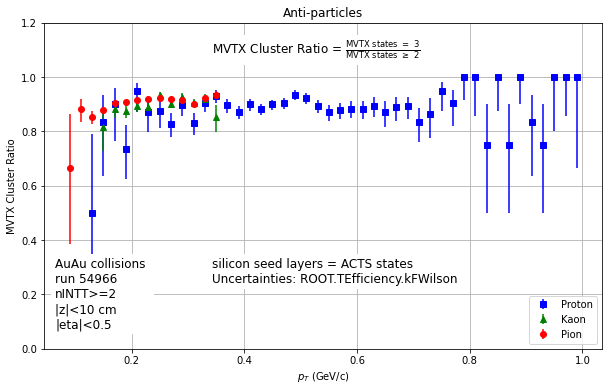

In [36]:
# Convert efficiencies to pyplot
fig, ax = plt.subplots(figsize=(10, 6))

#get numpy arrays
proton_b, proton_c, proton_e_l, proton_e_u = convertTEfficiency(efficiencies[0])
kaon_b, kaon_c, kaon_e_l, kaon_e_u = convertTEfficiency(efficiencies[1])
pion_b, pion_c, pion_e_l, pion_e_u = convertTEfficiency(efficiencies[2])

#remove zero bins, pyplot does not like them
mask_p = proton_c != 0
mask_K = kaon_c != 0
mask_pi = pion_c != 0

ax.errorbar(proton_b[mask_p], proton_c[mask_p], yerr=[proton_e_l[mask_p],proton_e_u[mask_p]], fmt='s', label='Proton', color='blue')
ax.errorbar(kaon_b[mask_K], kaon_c[mask_K], yerr=[kaon_e_l[mask_K],kaon_e_u[mask_K]], fmt='^', label='Kaon', color='green')
ax.errorbar(pion_b[mask_pi], pion_c[mask_pi], yerr=[pion_e_l[mask_pi],pion_e_u[mask_pi]], fmt='o', label='Pion', color='red')

ax.text(0.02, 0.28, f'{col_system} collisions \nrun {run_number}\nnINTT>=2\n|z|<10 cm\n|eta|<{eta_cut}', transform=ax.transAxes, fontsize=12, verticalalignment='top',bbox=dict(facecolor='white', alpha=1, edgecolor='none'))
ax.text(0.3, 0.95, r'MVTX Cluster Ratio = $\frac{\mathrm{MVTX\ states\ =\ 3}}{\mathrm{MVTX\ states\ \geq\ 2}}$', transform=ax.transAxes, fontsize=12, verticalalignment='top',bbox=dict(facecolor='white', alpha=1, edgecolor='none'))
ax.text(0.3, 0.28, f'silicon seed layers = ACTS states\nUncertainties: {eff_unc_name}', transform=ax.transAxes, fontsize=12, verticalalignment='top',bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

ax.set_xlabel('$p_{T}$ (GeV/c)')
ax.set_ylabel('MVTX Cluster Ratio')
ax.set_title('Anti-particles')
ax.legend(loc='lower right')
ax.grid(True)
plt.ylim(0, 1.2)

# Save the plot
plt.savefig(f"{output_path}/Cluster_ratios_{col_system}_{run_number}.png", facecolor='white')
plt.show()

In [37]:
# Do proton/pion efficiency ratio with error propagation
# Create an empty TGraphAsymmErrors
g_ratio = ROOT.TGraphAsymmErrors()

# Bin centers and widths from your original efficiencies
histo = eff_proton.GetPassedHistogram()

# Loop over bins
for i in range(1, histo.GetNbinsX() + 1):
    x_center = histo.GetXaxis().GetBinCenter(i)
    x_width = histo.GetXaxis().GetBinWidth(i) / 2
    # Get efficiencies and asymmetric errors
    A = eff_proton.GetEfficiency(i)
    A_up = eff_proton.GetEfficiencyErrorUp(i)
    A_low = eff_proton.GetEfficiencyErrorLow(i)

    B = eff_pion.GetEfficiency(i)
    B_up = eff_pion.GetEfficiencyErrorUp(i)
    B_low = eff_pion.GetEfficiencyErrorLow(i)

    # Avoid division by zero
    if B > 0 and A > 0:
        R = A / B

        # Propagate errors separately
        #Upper uncertainty of A and lower uncertainty of B affect the upper error of the ratio, and vice versa!
        R_up = R * math.sqrt( (A_up / A)**2 + (B_low / B)**2 )
        R_low = R * math.sqrt( (A_low / A)**2 + (B_up / B)**2 )

        # Set point and errors
        point = g_ratio.GetN()  # current number of points
        g_ratio.SetPoint(point, x_center, R)
        g_ratio.SetPointError(point, x_width, x_width, R_low, R_up)

In [38]:
x, y, xerr_low,xerr_up, yerr_low, yerr_up = convertGraph(g_ratio)
plt.errorbar(
    x, y, xerr=[xerr_low, xerr_up], yerr=[yerr_low, yerr_up],
    fmt='o', ecolor='red', markerfacecolor='red', markeredgecolor='red', capsize=3, markersize=5
)

plt.text(0.4, 0.28, f'{col_system} collisions \nrun {run_number}\nnINTT>=2\n|z|<10 cm\n|eta|<{eta_cut}', transform=ax.transAxes, fontsize=12, verticalalignment='top',bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

plt.xlabel('$p_{T}$ (GeV/c)')
plt.ylabel('Proton/Pion MVTX cluster Ratio')
plt.title('Proton/Pion ratio')
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_path}/Proton_pion_ratio_{col_system}_{run_number}.png", facecolor='white')
plt.show()

In [39]:
import ROOT
# Create or open a ROOT file
output_file = ROOT.TFile(f"{output_path}/Cluster_ratios_{col_system}_{run_number}.root", "RECREATE")  # "RECREATE" will overwrite if the file exists


hist.Write("dEdx")
histograms[0][0].Write("dEdx_proton")
histograms[1][0].Write("dEdx_kaon")
histograms[2][0].Write("dEdx_pion")

# Write each efficiency to the file
eff_proton.Write("proton_cluster_ratio")
eff_kaon.Write("kaon_cluster_ratio")
eff_pion.Write("pion_cluster_ratio")
g_ratio.Write("proton_pion_ratio")

# Always close the file properly
output_file.Close()